In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [306]:
import sqlite3

In [307]:
from scipy.io import wavfile  #for reading in clips
from scipy.signal import resample, hann
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from numpy.lib import stride_tricks  #for Schindler's stft function
from scipy.integrate import simps  #for rough power spectrum calcs

In [308]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, ConfusionMatrixDisplay, precision_recall_curve

from yellowbrick.target import FeatureCorrelation
from yellowbrick.model_selection import FeatureImportances, ValidationCurve, LearningCurve, CVScores
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ClassPredictionError
from yellowbrick.features import Rank2D, rank1d, rank2d

## Read in all clips with labels

In [309]:
db_file_path = './audio_labels.db'

data_dir = 'data'

conn = sqlite3.connect(db_file_path)

In [310]:
data = pd.read_sql("SELECT * FROM staging WHERE label!='UNLABELLED' AND duration_s >= 3", conn)

In [311]:
data['time_hour'] = pd.to_datetime(data.timestamp).dt.hour
data['time_hour_night'] = data.time_hour <= 6

In [312]:
data.head()

,filename,date,duration_s,timestamp,label,time_hour
0,20220310/record_221006.wav,20220310,22,2022-03-10 22:10:06,background,22
1,20220310/record_221256.wav,20220310,5,2022-03-10 22:12:56,background,22
2,20220310/record_222837.wav,20220310,6,2022-03-10 22:28:37,background,22
3,20220310/record_223013.wav,20220310,29,2022-03-10 22:30:13,watching tv,22
4,20220310/record_224105.wav,20220310,5,2022-03-10 22:41:05,me awake talking,22


Simplest features are duration and time of day

- Sleep talking will be most easily identified by time of day; almost nothing else occurs 1am-6am
- Background, cough, window are likely to be short duration
- Vehicle (plane) tends to be 20-30s

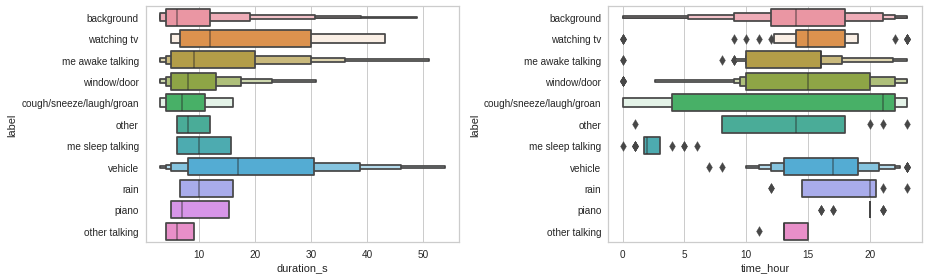

In [313]:
fig,axs = plt.subplots(1,2,figsize=(13,4))
sns.boxenplot(y='label', x='duration_s', data=data, ax=axs[0], showfliers=False)
sns.boxenplot(y='label', x='time_hour', data=data, ax=axs[1])
plt.tight_layout()

## Make audio features

### Time domain

In [314]:
clip1_samplerate, clip1_wav_data = wavfile.read(data_dir + '/' + data.filename.iloc[0])

In [315]:
clip1_samplerate, len(clip1_wav_data)

(16000, 360647)

In [316]:
clip1_wav_data[-clip1_samplerate:]

array([ -538,  -530,  -602, ...,  -371, -1352,  -827], dtype=int16)

In [317]:
def get_simple_audio_features(clip_filename, data_dir):
    clip_samplerate, clip_wav_data = wavfile.read(data_dir + '/' + clip_filename)
    
    max_abs = np.max(abs(clip_wav_data))
    
    mean_abs = np.mean(abs(clip_wav_data))
    
    std = np.std(clip_wav_data)
    
    max_over_mean = np.max(abs(clip_wav_data)) / np.mean(abs(clip_wav_data))
    
    if len(clip_wav_data) < 2*clip_samplerate:
        print('short', len(clip_wav_data), clip_samplerate)
        
    abs_first_last_1s = np.mean(np.abs(np.concatenate([clip_wav_data[:clip_samplerate],
                                                clip_wav_data[-clip_samplerate:]])))
    abs_first_last_1s_over_middle = abs_first_last_1s / np.mean(np.abs(clip_wav_data[clip_samplerate:-clip_samplerate]))
    
    abs_first_half_s = np.mean(np.abs(clip_wav_data[:int(0.5*clip_samplerate)]))
    
    
    return pd.Series((max_abs, mean_abs, std, max_over_mean,
                      abs_first_last_1s, abs_first_last_1s_over_middle,
                      abs_first_half_s))

In [318]:
simple_time_features = ['max_abs_wav','mean_abs_wav','stdev_wav','max_over_mean_wav',
                        'abs_first_last_1s','abs_first_last_1s_over_middle',
                        'abs_first_half_s']

data[simple_time_features] = data.filename.apply(get_simple_audio_features, args=(data_dir,))

In [319]:
data.groupby('label', as_index=False)[simple_time_features].mean()\
    .sort_values('max_abs_wav', ascending=False)

,label,max_abs_wav,mean_abs_wav,stdev_wav,max_over_mean_wav,abs_first_last_1s,abs_first_last_1s_over_middle,abs_first_half_s
10,window/door,19267.487805,511.988852,1160.424865,37.361894,751.695849,2.182362,1152.218427
1,cough/sneeze/laugh/groan,17225.387097,431.364977,933.012508,40.054654,709.720946,2.403967,1186.854308
4,other,12200.100000,397.298063,753.147642,31.674131,499.901922,1.492560,909.468150
7,rain,10451.285714,446.129787,742.666457,23.276126,467.504804,1.104657,724.842732
0,background,6449.703088,418.045636,617.630173,16.173674,514.507598,1.463664,772.173429
9,watching tv,5518.491525,438.378572,633.003258,12.379054,544.247807,1.400789,779.834239
2,me awake talking,4993.269939,363.173815,508.737495,13.603662,448.966861,1.348529,638.380280
3,me sleep talking,4838.208333,353.118557,522.343888,13.454247,442.475227,1.408765,602.832630
8,vehicle,3749.307263,440.339241,574.240667,8.530309,500.404223,1.194242,678.947848
5,other talking,3607.000000,373.474611,509.542762,9.367218,473.489638,1.509807,756.048775


- Cough and window will stand out by high max abs and high first last 1s over middle
- Window can have high stdev
- Vehicle has quite high mean_abs and low max/mean
- Talking and piano are low mean_abs

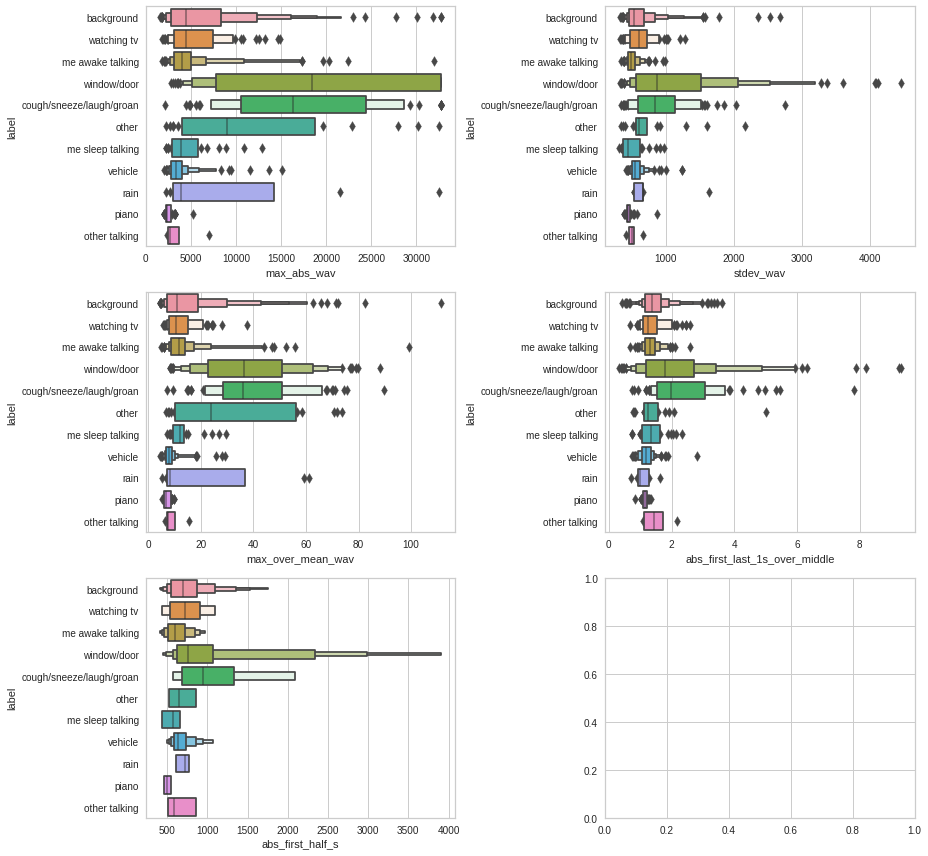

In [320]:
fig,axs = plt.subplots(3,2,figsize=(13,12))
sns.boxenplot(y='label', x='max_abs_wav', data=data, ax=axs[0][0])
sns.boxenplot(y='label', x='stdev_wav', data=data, ax=axs[0][1])
sns.boxenplot(y='label', x='max_over_mean_wav', data=data, ax=axs[1][0])
sns.boxenplot(y='label', x='abs_first_last_1s_over_middle', data=data, ax=axs[1][1])
sns.boxenplot(y='label', x='abs_first_half_s', data=data, ax=axs[2][0], showfliers=False)
plt.tight_layout()

Several features from http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html

In [321]:
#Zero crossing rate

def zero_crossing_rate(clip_filename, block_length, data_dir):
    
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    
    # how many blocks have to be processed?
    num_blocks = int(np.ceil(len(wavedata)/block_length))
    #print(num_blocks)
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,num_blocks - 1) * (block_length / float(sample_rate)))
    
    zcr = []
    
    for i in range(0,num_blocks-1):
        
        start = i * block_length
        stop  = np.min([(start + block_length - 1), len(wavedata)])
        
        zc = 0.5 * np.mean(np.abs(np.diff(np.sign(wavedata[start:stop]))))
        zcr.append(zc)
    
    return np.asarray(zcr), np.asarray(timestamps)

def get_zcr_features(clip_filename, block_length, data_dir):
    zcrs, times = zero_crossing_rate(clip_filename, block_length, data_dir)
    
    return pd.Series((np.mean(zcrs), np.max(zcrs), np.std(zcrs)))

0    0.048079
1    0.310850
2    0.048200
dtype: float64


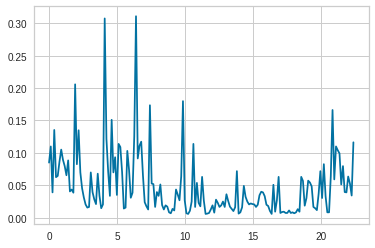

In [322]:
zcrs, times = zero_crossing_rate(data.filename.iloc[0], 2048, data_dir)
plt.plot(times, zcrs)

print(get_zcr_features(data.filename.iloc[0], 2048, data_dir))

In [323]:
zcr_features = ['mean_zero_crossing_rate','max_zero_crossing_rate','stdev_zero_crossing_rate']
data[zcr_features] = data.apply(lambda row: get_zcr_features(row['filename'], 2048, data_dir), axis=1)

data.groupby('label', as_index=False)[zcr_features].mean()\
    .sort_values('mean_zero_crossing_rate', ascending=False)

,label,mean_zero_crossing_rate,max_zero_crossing_rate,stdev_zero_crossing_rate
4,other,0.085270,0.325147,0.069158
10,window/door,0.065211,0.342379,0.062402
1,cough/sneeze/laugh/groan,0.063561,0.269566,0.053908
6,piano,0.055764,0.138947,0.026102
7,rain,0.053361,0.139715,0.020282
2,me awake talking,0.039250,0.227705,0.038187
0,background,0.034223,0.134343,0.023337
8,vehicle,0.034032,0.061818,0.007927
9,watching tv,0.033323,0.088151,0.014529
3,me sleep talking,0.032976,0.253829,0.040332


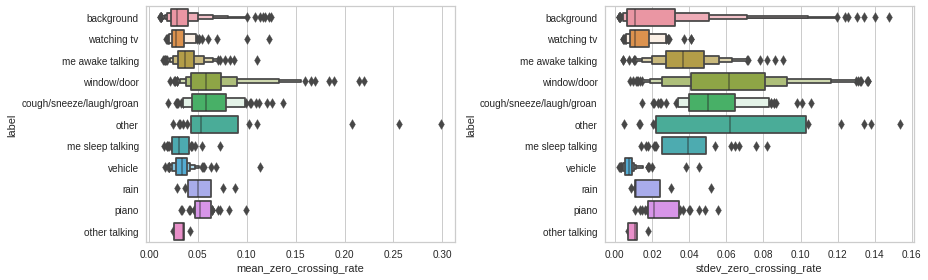

In [324]:
fig,axs = plt.subplots(1,2,figsize=(13,4))
sns.boxenplot(y='label', x='mean_zero_crossing_rate', data=data, ax=axs[0])
sns.boxenplot(y='label', x='stdev_zero_crossing_rate', data=data, ax=axs[1])
plt.tight_layout()

In [325]:
#root mean square

def root_mean_square(clip_filename, block_length, data_dir):
    
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    wavedata = wavedata.astype(float)  #Crucial if we are squaring it!
    
    # how many blocks have to be processed?
    num_blocks = int(np.ceil(len(wavedata)/block_length))
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,num_blocks - 1) * (block_length / float(sample_rate)))
    
    rms = []    
    for i in range(0,num_blocks-1):        
        start = i * block_length
        stop  = np.min([(start + block_length - 1), len(wavedata)])        
        rms_seg = np.sqrt(np.mean(wavedata[start:stop]**2))
        rms.append(rms_seg)
    
    return np.asarray(rms), np.asarray(timestamps)

def get_rms_features(clip_filename, block_length, data_dir):
    rmss, times = root_mean_square(clip_filename, block_length, data_dir)
    
    return pd.Series((np.mean(rmss), np.max(rmss), np.std(rmss)))

In [326]:
rms_features = ['mean_rms','max_rms','stdev_rms']
data[rms_features] = data.apply(lambda row: get_rms_features(row['filename'], 2048, data_dir), axis=1)

data.groupby('label', as_index=False)[rms_features].mean()\
    .sort_values('mean_rms', ascending=False)

,label,mean_rms,max_rms,stdev_rms
10,window/door,679.270513,5891.030324,912.262268
1,cough/sneeze/laugh/groan,587.896765,4153.415982,705.175036
7,rain,561.508680,3272.007024,406.553368
9,watching tv,548.988455,1824.385358,299.572890
8,vehicle,547.368301,1220.664179,165.155113
0,background,524.416963,1893.543739,300.591079
4,other,510.096267,3477.086277,500.825689
5,other talking,463.409629,1266.281495,194.844439
2,me awake talking,454.962607,1464.305697,216.011965
3,me sleep talking,448.032956,1665.770361,253.919672


Mean and stdev rms are strongly correlated; similar to max_abs

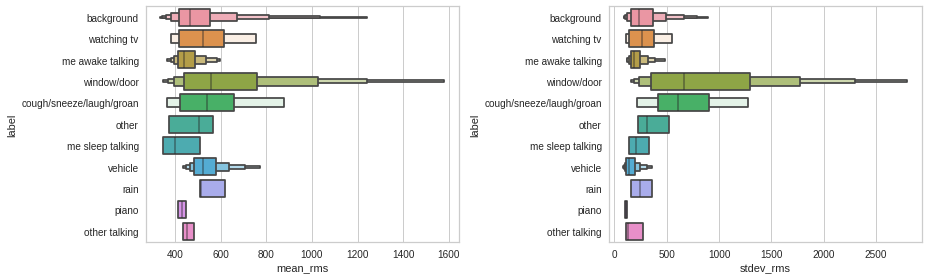

In [327]:
fig,axs = plt.subplots(1,2,figsize=(13,4))
sns.boxenplot(y='label', x='mean_rms', data=data, ax=axs[0], showfliers=False)
sns.boxenplot(y='label', x='stdev_rms', data=data, ax=axs[1], showfliers=False)
plt.tight_layout()

### Frequency domain

In [328]:
#Spectral centroid - It determines the frequency area around which most of the signal energy concentrates;
#  gives an indication of how dark or bright the sound is

# = frequency weighted sum of power spectrum, normalised by unweighted sum
# so higher values when high frequencies contribute more power to the spectrum sum?

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    
    # cols for windowing
    cols = int(np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1)
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, 
                                      shape=(cols, frameSize), 
                                      strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)


def spectral_centroid(clip_filename, window_size, data_dir):
    
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    wavedata = wavedata.astype(float)
    
    magnitude_spectrum = stft(wavedata, window_size)
    
    timebins, freqbins = np.shape(magnitude_spectrum)
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,timebins - 1) * (timebins / float(sample_rate)))
    
    sc = []
    for t in range(timebins-1):        
        power_spectrum = np.abs(magnitude_spectrum[t])**2        
        sc_t = np.sum(power_spectrum * np.arange(1,freqbins+1)) / np.sum(power_spectrum)        
        sc.append(sc_t)        
    
    sc = np.asarray(sc)
    sc = np.nan_to_num(sc)
    
    return sc, np.asarray(timestamps)

def get_spectral_centroid_features(clip_filename, window_size, data_dir):
    scs, times = spectral_centroid(clip_filename, window_size, data_dir)
    
    return pd.Series((np.mean(scs), np.max(scs), np.std(scs)))

In [329]:
sc_features = ['mean_sc','max_sc','stdev_sc']
data[sc_features] = data.apply(lambda row: get_spectral_centroid_features(row['filename'], 1024, data_dir), axis=1)

data.groupby('label', as_index=False)[sc_features].mean()\
    .sort_values('mean_sc', ascending=False)

,label,mean_sc,max_sc,stdev_sc
4,other,32.363113,178.456166,36.420830
10,window/door,22.363908,207.188598,33.222072
1,cough/sneeze/laugh/groan,20.093520,160.402183,24.051550
6,piano,19.389754,66.019366,11.743370
7,rain,15.421575,93.304724,10.211266
8,vehicle,13.493185,28.775882,3.456656
2,me awake talking,12.880237,119.528270,13.195021
3,me sleep talking,12.157297,148.248298,14.902830
5,other talking,10.995243,29.029775,4.357951
0,background,10.977529,76.805303,9.846487


In [330]:
#Spectral rolloff
#- the frequency below which some fraction, k (typically 0.85, 0.9 or 0.95 percentile), of the cumulative spectral power resides
#- measure of the skewness of the spectral shape
#- indication of how much energy is in the lower frequencies
#- it is used to distinguish voiced from unvoiced speech or music


def spectral_rolloff(clip_filename, window_size, data_dir, k=0.85):
    
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    wavedata = wavedata.astype(float)
    
    # convert to frequency domain
    magnitude_spectrum = stft(wavedata, window_size)
    power_spectrum     = np.abs(magnitude_spectrum)**2
    timebins, freqbins = np.shape(magnitude_spectrum)
    
    # when do these blocks begin (time in seconds)?
    timestamps = (np.arange(0,timebins - 1) * (timebins / float(sample_rate)))
    
    sr = []

    spectralSum    = np.sum(power_spectrum, axis=1)
    
    for t in range(timebins-1):        
        # find frequency-bin indeces where the cummulative sum of all bins is higher
        # than k-percent of the sum of all bins. Lowest index = Rolloff
        sr_t = np.where(np.cumsum(power_spectrum[t,:]) >= k * spectralSum[t])[0][0]
        sr.append(sr_t)
    sr = np.asarray(sr).astype(float)
    
    # convert frequency-bin index to frequency in Hz
    sr = (sr / freqbins) * (sample_rate / 2.0)
    
    return sr, np.asarray(timestamps)

def get_spectral_rolloff_features(clip_filename, window_size, data_dir):
    srs, times = spectral_rolloff(clip_filename, window_size, data_dir)
    
    return pd.Series((np.mean(srs), np.max(srs), np.std(srs)))

In [331]:
sr_features = ['mean_sr','max_sr','stdev_sr']
data[sr_features] = data.apply(lambda row: get_spectral_rolloff_features(row['filename'], 1024, data_dir), axis=1)

data.groupby('label', as_index=False)[sr_features].mean()\
    .sort_values('mean_sr', ascending=False)

,label,mean_sr,max_sr,stdev_sr
4,other,817.865733,3735.672515,930.708928
10,window/door,537.372312,4985.537013,993.868274
6,piano,497.860815,1658.590922,359.197606
1,cough/sneeze/laugh/groan,467.733864,4417.028234,764.307229
7,rain,313.519172,2256.752994,320.143223
8,vehicle,311.653773,761.344703,106.804986
2,me awake talking,276.685193,4244.968249,545.829679
3,me sleep talking,251.108444,4291.747888,529.165813
5,other talking,218.667318,1026.120858,146.864769
0,background,217.628356,2052.701032,300.757452


### Use FFT myself

https://realpython.com/python-scipy-fft/
https://raphaelvallat.com/bandpower.html


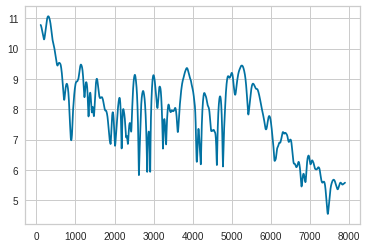

In [332]:
w = np.hanning(5001)
yf_sm = np.convolve(w/w.sum(), yf, mode='valid')
plt.plot(xf[2500:-2500], np.log(abs(yf_sm)))

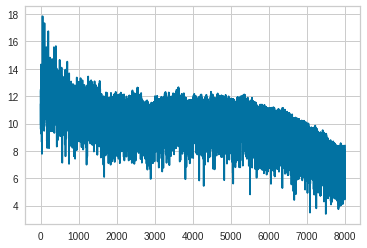

In [333]:
#from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
#N = SAMPLE_RATE * DURATION

#yf = fft(clip1_wav_data)  #calculate Fourier transform; returns complex values so use abs below
#xf = fftfreq(len(clip1_wav_data), 1 / clip1_samplerate)  #calculate the frequencies at bin centres, to plot
#plt.plot(xf, np.abs(yf))
#plt.show()

#fft returns a signal mirrored about y axis; rfft is the same but only gives positive half
yf = rfft(clip1_wav_data)  #calculate Fourier transform; returns complex values so use abs below
xf = rfftfreq(len(clip1_wav_data), 1 / clip1_samplerate)  #calculate the frequencies at bin centres, to plot
plt.plot(xf, np.log(np.abs(yf)))
plt.show()



In [334]:
#Power (some units) may be the area under this curve

total_power = simps(np.abs(yf), dx=xf[1]-xf[0])

#Then relative power in certain bands is

# < 1khz
print(simps(np.abs(yf)[xf <= 1000], dx=xf[1]-xf[0]) / total_power)

# 1-3 khz
print(simps(np.abs(yf)[(xf > 1000) & (xf <= 3000)], dx=xf[1]-xf[0]) / total_power)

# >= 3 khz
print(simps(np.abs(yf)[xf > 3000], dx=xf[1]-xf[0]) / total_power)

0.48169394354729217
0.24259026663657204
0.275557608620496


In [385]:
def get_crude_spectral_power_fractions(clip_filename, data_dir):
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    yf = rfft(wavedata) 
    xf = rfftfreq(len(wavedata), 1 / sample_rate)
    
    delta_freq = xf[1]-xf[0]
    total_power = simps(np.abs(yf), dx=delta_freq)
    
    return pd.Series((simps(np.abs(yf)[(xf <= 100)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 100) & (xf <= 400)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 400) & (xf <= 1000)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 1000) & (xf <= 3000)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 3000)], dx=delta_freq) / total_power))

In [386]:
get_crude_spectral_power_fractions(data.filename.iloc[5], data_dir)

0    0.079746
1    0.346140
2    0.091985
3    0.336977
4    0.140763
dtype: float64

In [432]:
my_specpower_features = ['specpowerfrac_0_100','specpowerfrac_100_400',
                         'specpowerfrac_400_1000','specpowerfrac_1000_3000',
                         'specpowerfrac_3000_8000']
data[my_specpower_features] = data.filename.apply(get_crude_spectral_power_fractions, args=(data_dir,))

data.groupby('label', as_index=False)[my_specpower_features].mean()\
    .sort_values('specpowerfrac_100_400', ascending=False)

#Vehicle has most in low freq; cough, window most in high freq

,label,specpowerfrac_0_100,specpowerfrac_100_400,specpowerfrac_400_1000,specpowerfrac_1000_3000,specpowerfrac_3000_8000
8,vehicle,0.130260,0.426569,0.274608,0.127932,0.038522
3,me sleep talking,0.052213,0.401149,0.190115,0.140309,0.213038
2,me awake talking,0.069056,0.397479,0.149217,0.171086,0.209731
5,other talking,0.229603,0.298227,0.249646,0.158918,0.058771
9,watching tv,0.291557,0.288623,0.161089,0.161417,0.095462
7,rain,0.161781,0.286566,0.182172,0.195946,0.172266
0,background,0.253020,0.278289,0.129037,0.155188,0.180259
6,piano,0.102748,0.254268,0.290843,0.274283,0.073267
1,cough/sneeze/laugh/groan,0.045034,0.227013,0.194881,0.252906,0.278588
4,other,0.140411,0.149872,0.131437,0.204441,0.371266


<AxesSubplot:xlabel='specpower', ylabel='value'>

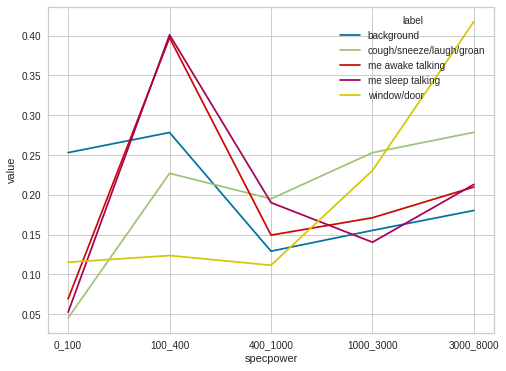

In [388]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.lineplot(x='specpower', y='value', hue='label', 
             data=data.groupby('label', as_index=False)[my_specpower_features].mean()\
                 .rename(columns = lambda x: x.replace('specpowerfrac_',''))\
                 .melt(id_vars=['label'], var_name='specpower')\
                 .query("label in ['me awake talking','me sleep talking','window/door','background','cough/sneeze/laugh/groan']"),
             ax=ax)
#_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
#ax.get_xticklabels()

Also look at first 1s only?

In [475]:
def get_crude_spectral_power_fractions_first_1s(clip_filename, data_dir):
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    yf = rfft(wavedata[:int(sample_rate)]) 
    xf = rfftfreq(int(sample_rate), 1 / sample_rate)
    
    delta_freq = xf[1]-xf[0]
    total_power = simps(np.abs(yf), dx=delta_freq)
    
    return pd.Series((simps(np.abs(yf)[(xf <= 100)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 100) & (xf <= 400)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 400) & (xf <= 1000)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 1000) & (xf <= 3000)], dx=delta_freq) / total_power,
                      simps(np.abs(yf)[(xf > 3000)], dx=delta_freq) / total_power))

<AxesSubplot:xlabel='specpower', ylabel='value'>

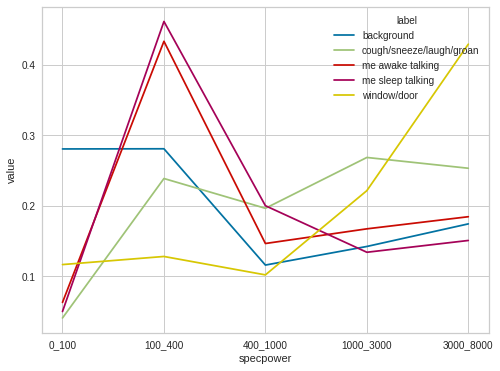

In [476]:
my_specpower_features_first_1s = [x+'_first_1s' for x in my_specpower_features]
data[my_specpower_features_first_1s] = data.filename.apply(get_crude_spectral_power_fractions_first_1s, args=(data_dir,))

fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.lineplot(x='specpower', y='value', hue='label', 
             data=data.groupby('label', as_index=False)[my_specpower_features_first_1s].mean()\
                 .rename(columns = lambda x: x.replace('specpowerfrac_','').replace('_first_1s',''))\
                 .melt(id_vars=['label'], var_name='specpower')\
                 .query("label in ['me awake talking','me sleep talking','window/door','background','cough/sneeze/laugh/groan']"),
             ax=ax)

In [436]:
#Means look very similar but correlations are not perfect

print(np.corrcoef(data.specpowerfrac_0_100, data.specpowerfrac_0_100_first_1s)[0][1])
print(np.corrcoef(data.specpowerfrac_100_400, data.specpowerfrac_100_400_first_1s)[0][1])
print(np.corrcoef(data.specpowerfrac_400_1000, data.specpowerfrac_400_1000_first_1s)[0][1])
print(np.corrcoef(data.specpowerfrac_1000_3000, data.specpowerfrac_1000_3000_first_1s)[0][1])
print(np.corrcoef(data.specpowerfrac_3000_8000, data.specpowerfrac_3000_8000_first_1s)[0][1])

0.8979152752750387
0.8660901804693877
0.8855949908272726
0.8130085816151008
0.8297721404316346


Yaafe provides many other features http://yaafe.sourceforge.net/features.html, including (mostly by 'frame')
- Centroid, spread, skewness and kurtosis of each frame’s amplitude envelope
- loudness coefficients - the energy in each Bark band
- MFCC - Mel-frequencies cepstrum coefficients
- Spectral flux, rolloff, spectrum shape statistics

But it doesn't look as easy to install as PyAudioAnalysis so use that instead.

`ShortTermFeatures` returns 34 features, some of which I had above but others new including MFCC coefficients.


In [389]:
from pyAudioAnalysis import ShortTermFeatures

In [390]:
#[Fs, x] = audioBasicIO.read_audio_file("sample.wav")

#Parameters are wavdata, sample rate, frame size (50ms), frame step (25ms, meaning there is 50% overlap)
F, f_names = ShortTermFeatures.feature_extraction(clip1_wav_data, clip1_samplerate, 
                                                  0.050*clip1_samplerate, 
                                                  0.25*clip1_samplerate,
                                                  deltas=False)


In [391]:
f_names

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std']

Text(0, 0.5, 'chroma_std')

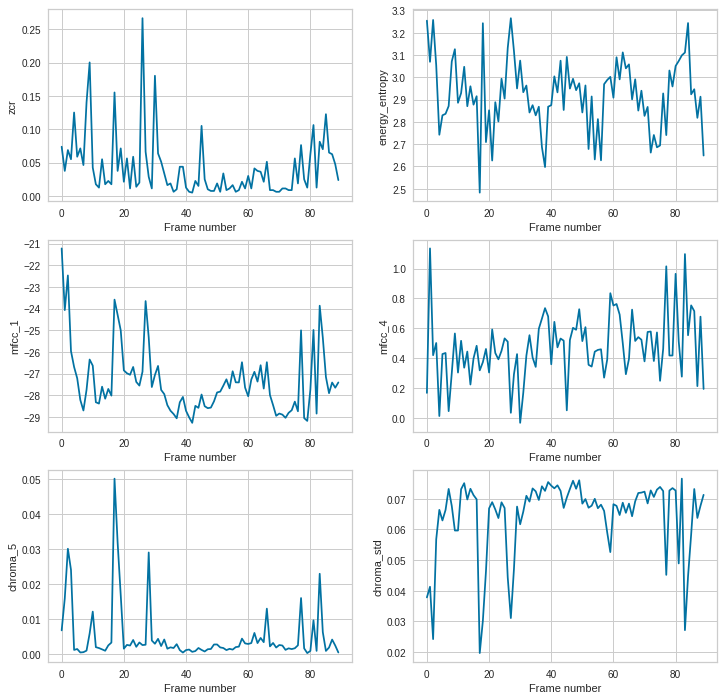

In [392]:
fig, ax = plt.subplots(3, 2, figsize=(12,12))

ax[0][0].plot(F[0,:])
ax[0][0].set_xlabel('Frame number')
ax[0][0].set_ylabel(f_names[0])

ax[0][1].plot(F[2,:])
ax[0][1].set_xlabel('Frame number')
ax[0][1].set_ylabel(f_names[2])

ax[1][0].plot(F[8,:])
ax[1][0].set_xlabel('Frame number')
ax[1][0].set_ylabel(f_names[8])

ax[1][1].plot(F[11,:])
ax[1][1].set_xlabel('Frame number')
ax[1][1].set_ylabel(f_names[11])

ax[2][0].plot(F[25,:])
ax[2][0].set_xlabel('Frame number')
ax[2][0].set_ylabel(f_names[25])

ax[2][1].plot(F[33,:])
ax[2][1].set_xlabel('Frame number')
ax[2][1].set_ylabel(f_names[33])

How much do frame length and step matter if we are averaging anyway?

Step can be increased from 25ms to 0.25s without any change in means. Frame length can optionally also be increased from 50ms to 0.5s. Stdevs are very slightly affected.

In [393]:
F_pt05_pt025, f_names = ShortTermFeatures.feature_extraction(
    clip1_wav_data, clip1_samplerate, 
    0.050*clip1_samplerate, 
    0.025*clip1_samplerate,
    deltas=False)

F_pt05_pt25, f_names = ShortTermFeatures.feature_extraction(
    clip1_wav_data, clip1_samplerate, 
    0.050*clip1_samplerate, 
    0.25*clip1_samplerate,
    deltas=False)

F_pt5_pt25, f_names = ShortTermFeatures.feature_extraction(
    clip1_wav_data, clip1_samplerate, 
    0.50*clip1_samplerate, 
    0.25*clip1_samplerate,
    deltas=False)

F_pt5_pt25, f_names = ShortTermFeatures.feature_extraction(
    clip1_wav_data, clip1_samplerate, 
    0.50*clip1_samplerate, 
    0.25*clip1_samplerate,
    deltas=False)

print(np.corrcoef([np.mean(x) for x in F_pt05_pt025],
                  [np.mean(x) for x in F_pt05_pt25])[0][1])
print(np.corrcoef([np.mean(x) for x in F_pt05_pt025],
                  [np.mean(x) for x in F_pt5_pt25])[0][1])

print(np.corrcoef([np.std(x) for x in F_pt05_pt025],
                  [np.std(x) for x in F_pt05_pt25])[0][1])
print(np.corrcoef([np.std(x) for x in F_pt05_pt025],
                  [np.std(x) for x in F_pt5_pt25])[0][1])



0.9999947848337133
0.999575217983627
0.99791835657674
0.9970189130098491


In [506]:
a = [0,2,4]
b = [1,3,5]
#pd.Series((a[0],b[0],a[1],b[1],a[2],b[2]))
[i for j in [(x,y) for (x,y) in zip(a,b)] for i in j]

[0, 1, 2, 3, 4, 5]

In [513]:
def get_agg_pyaudioanalysis_features(clip_filename, data_dir, frame_size=0.05, frame_step=0.025):
    
    sample_rate, wavedata = wavfile.read(data_dir + '/' + clip_filename)
    wavedata = wavedata.astype(float)
    
    F, f_names = ShortTermFeatures.feature_extraction(
        wavedata, sample_rate,
        frame_size*sample_rate, 
        frame_step*sample_rate,
        deltas=False)
    
    F_means = F.mean(axis=1)
    F_stdevs = F.std(axis=1)
    
#     return pd.Series((F_means[0], F_stdevs[0],
#                       F_means[1], F_stdevs[1],
#                       F_means[2], F_stdevs[2],
#                       F_means[3], F_stdevs[3],
#                       F_means[4], F_stdevs[4],
#                       F_means[5], F_stdevs[5],
#                       F_means[6], F_stdevs[6],
#                       F_means[7], F_stdevs[7],
#                       F_means[8], F_stdevs[8],
#                       F_means[9], F_stdevs[9],
#                       F_means[10], F_stdevs[10],
#                       F_means[11], F_stdevs[11],
#                       F_means[12], F_stdevs[12],
#                       F_means[13], F_stdevs[13],
#                       F_means[14], F_stdevs[14],
#                       F_means[15], F_stdevs[15],
#                       F_means[16], F_stdevs[16],
#                       F_means[17], F_stdevs[17],
#                       F_means[18], F_stdevs[18],
#                       F_means[19], F_stdevs[19],
#                       F_means[20], F_stdevs[20],
#                      ))
    zipped_features = [(m,s) for (m,s) in zip(F_means[:21], F_stdevs[:21])]
    return pd.Series([i for j in zipped_features for i in j])
    

In [512]:
tmp = data.head(30).filename.apply(get_agg_pyaudioanalysis_features, args=(data_dir,),
                                   frame_size=0.5, frame_step=0.25)
tmp.shape


(30, 42)

In [396]:
paa_features = ['paa_zcr_mean','paa_zcr_std',
                'paa_energy_mean','paa_energy_std',
                'paa_energyentropy_mean','paa_energyentropy_std',
                'paa_sc_mean','paa_sc_std',
                'paa_ss_mean','paa_ss_std',
                'paa_se_mean','paa_se_std',
                'paa_sf_mean','paa_sf_std',
                'paa_sr_mean','paa_sr_std',
                'paa_mcc1_mean','paa_mcc1_std',
                'paa_mcc2_mean','paa_mcc2_std',
                'paa_mcc3_mean','paa_mcc3_std',
                'paa_mcc4_mean','paa_mcc4_std',
                'paa_mcc5_mean','paa_mcc5_std',
                'paa_mcc6_mean','paa_mcc6_std',
                'paa_mcc7_mean','paa_mcc7_std',
                'paa_mcc8_mean','paa_mcc8_std',
                'paa_mcc9_mean','paa_mcc9_std',
                'paa_mcc10_mean','paa_mcc10_std',
                'paa_mcc11_mean','paa_mcc11_std',
                'paa_mcc12_mean','paa_mcc12_std',
                'paa_mcc13_mean','paa_mcc13_std']

#Takes 2 minutes for 1000 files if frame_size=0.5
data[paa_features] = data.filename.apply(get_agg_pyaudioanalysis_features, args=(data_dir,),
                                         frame_size=0.5, frame_step=0.25)

data.groupby('label', as_index=False)[paa_features].mean()\
    .sort_values('paa_mcc1_mean', ascending=False)

,label,paa_zcr_mean,paa_zcr_std,paa_energy_mean,paa_energy_std,paa_energyentropy_mean,paa_energyentropy_std,paa_sc_mean,paa_sc_std,paa_ss_mean,...,paa_mcc9_mean,paa_mcc9_std,paa_mcc10_mean,paa_mcc10_std,paa_mcc11_mean,paa_mcc11_std,paa_mcc12_mean,paa_mcc12_std,paa_mcc13_mean,paa_mcc13_std
6,piano,0.055053,0.020282,0.032880,0.013308,3.239831,0.078878,0.116356,0.016789,0.150333,...,0.105726,0.260667,-0.008138,0.228826,0.065070,0.201425,0.096325,0.160712,-0.002950,0.129997
8,vehicle,0.034067,0.006377,0.028534,0.015256,3.257502,0.052394,0.085667,0.011350,0.128896,...,0.117573,0.090183,0.038694,0.080768,-0.012089,0.082370,0.044946,0.075188,0.015834,0.070494
5,other talking,0.032491,0.008400,0.024514,0.015519,3.246739,0.075433,0.100782,0.014041,0.149883,...,0.198087,0.104795,0.038487,0.106766,0.022445,0.095339,0.142626,0.086732,0.034089,0.084916
7,rain,0.053252,0.013978,0.022597,0.012875,3.184344,0.189002,0.165714,0.030552,0.201575,...,0.105355,0.071191,0.048569,0.076677,0.018817,0.068019,0.083786,0.078875,0.029152,0.075387
9,watching tv,0.033342,0.011069,0.019751,0.015578,3.151324,0.185479,0.118304,0.025358,0.168498,...,0.213035,0.127464,0.187146,0.112567,0.056093,0.108725,0.131095,0.097631,0.034243,0.095764
0,background,0.033895,0.016034,0.020602,0.015277,3.149652,0.227197,0.135985,0.037687,0.182681,...,0.182726,0.092297,0.118046,0.080650,0.074545,0.077213,0.082099,0.074920,0.001745,0.071421
2,me awake talking,0.038945,0.025705,0.016541,0.011312,3.133492,0.196980,0.158460,0.053135,0.208783,...,0.051489,0.229891,0.203307,0.144960,0.050998,0.159379,0.167302,0.136160,0.105853,0.154566
3,me sleep talking,0.032928,0.029245,0.015175,0.012905,3.137380,0.231990,0.164104,0.055368,0.216345,...,0.033697,0.216695,0.186747,0.142534,0.052154,0.172665,0.050467,0.142672,-0.092935,0.150255
4,other,0.083196,0.051397,0.010234,0.009728,3.088654,0.361934,0.204063,0.067894,0.198085,...,0.154779,0.167018,0.080752,0.129019,0.062650,0.132828,0.111743,0.113325,0.016073,0.101717
10,window/door,0.063333,0.044363,0.005077,0.009917,3.017793,0.429307,0.207311,0.074780,0.216798,...,0.136540,0.124761,0.090468,0.092748,0.049427,0.086902,0.069097,0.090049,0.003218,0.085226


### Summary and choose features

Clip label = background
max_abs_wav                    = 9613 (73%)
mean_abs_wav                   = 1229.52 (99%)
stdev_wav                      = 1775.42 (96%)
max_over_mean_wav              = 7.81852 (24%)
abs_first_last_1s              = 1106.55 (96%)
abs_first_last_1s_over_middle  = 0.788686 (3%)
abs_first_half_s               = 1501.96 (94%)
mean_zero_crossing_rate        = 0.011843 (0%)
max_zero_crossing_rate         = 0.0254154 (1%)
stdev_zero_crossing_rate       = 0.00560773 (12%)
mean_sc                        = 4.92528 (0%)
max_sc                         = 9.98577 (1%)
stdev_sc                       = 1.42351 (7%)
mean_sr                        = 88.7123 (1%)
max_sr                         = 202.729 (2%)
stdev_sr                       = 32.9325 (6%)
specpowerfrac_0_100            = 0.607389 (100%)
specpowerfrac_100_400          = 0.254495 (48%)
specpowerfrac_400_1000         = 0.0650109 (9%)
specpowerfrac_1000_3000        = 0.0478251 (0%)
specpowerfrac_3000_8000        = 0.0

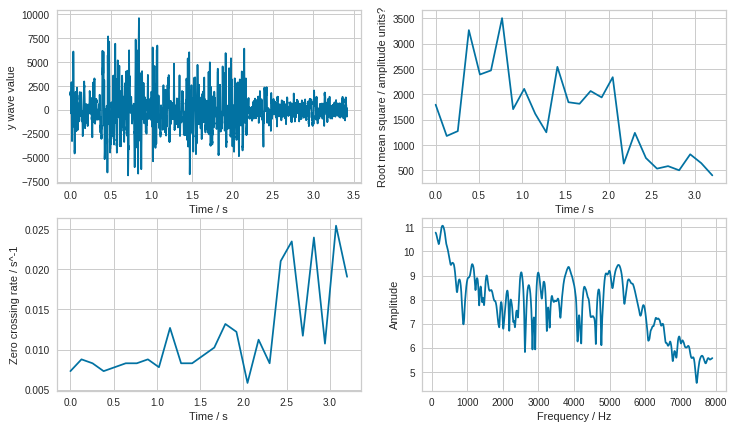

In [397]:
#TODO add paa bits

def show_clip(clip_filename, data_dir, data, features):
    clip_samplerate, clip_wav_data = wavfile.read(data_dir + '/' + clip_filename)
        
    fig, axs = plt.subplots(2,2, figsize=(12,7))
    axs[0][0].plot(np.linspace(0, len(clip_wav_data)/clip_samplerate, len(clip_wav_data)), clip_wav_data)
    axs[0][0].set_xlabel('Time / s')
    axs[0][0].set_ylabel('y wave value')
    
    zcrs, times = zero_crossing_rate(clip_filename, 2048, data_dir)
    axs[1][0].plot(times, zcrs)
    axs[1][0].set_xlabel('Time / s')
    axs[1][0].set_ylabel('Zero crossing rate / s^-1')
    
    rmss, times = root_mean_square(clip_filename, 2048, data_dir)
    axs[0][1].plot(times, rmss)
    axs[0][1].set_xlabel('Time / s')
    axs[0][1].set_ylabel('Root mean square / amplitude units?')
    
    yf = rfft(clip1_wav_data)  #calculate Fourier transform; returns complex values so use abs below
    xf = rfftfreq(len(clip1_wav_data), 1 / clip1_samplerate)  #calculate the frequencies at bin centres, to plot
    #axs[1][1].plot(xf, np.log(np.abs(yf)))
    #smooth it a lot
    w = np.hanning(5001)
    yf_sm = np.convolve(w/w.sum(), yf, mode='valid')
    axs[1][1].plot(xf[2500:-2500], np.log(abs(yf_sm)))
    axs[1][1].set_xlabel('Frequency / Hz')
    axs[1][1].set_ylabel('Amplitude')
    
    
    this_row = data[data.filename==clip_filename].iloc[0]
    print(f'Clip label = {this_row.label}')
    
    for feature in features:
        value_rank_pct = data[feature].rank(pct=True)[data.filename==clip_filename].iloc[0]*100
        print(f"{feature:30s} = {this_row[feature]:g} ({value_rank_pct:.0f}%)")
    
    
show_clip(data.filename.iloc[221], data_dir, data, simple_time_features + zcr_features + \
          sc_features + sr_features + my_specpower_features)

<AxesSubplot:>

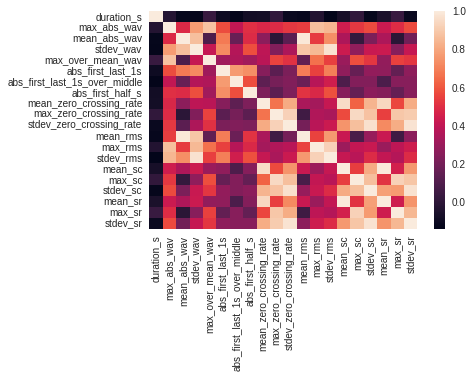

In [398]:
#zcr quite correlated with max_abs
#mean_rms is almost the same as max_abs

sns.heatmap(data[['duration_s'] + simple_time_features + zcr_features + rms_features + sc_features + sr_features].corr())

In [399]:
data.label.value_counts()

background                  421
window/door                 205
vehicle                     179
me awake talking            163
cough/sneeze/laugh/groan     62
watching tv                  59
piano                        28
me sleep talking             24
other                        20
rain                          7
other talking                 5
Name: label, dtype: int64

In [515]:
nonpaa_spectral_features = sc_features + sr_features #+ my_specpower_features

features = ['duration_s','time_hour','time_hour_night'] + \
    paa_features + my_specpower_features + my_specpower_features_first_1s + ['max_abs_wav','abs_first_half_s']

#simple_time_features + \
#zcr_features + \
#rms_features + \
#nonpaa_spectral_features + \
    

X, y = data[features], data['label'].copy()

#Combine small classes
y[y.isin(['other','rain','other talking'])] = 'other'
#y[y.isin(['me awake talking','me sleep talking'])] = 'me talking'
#y[y.isin(['watching tv'])] = 'tv/music'  #rename to what it really is
y.value_counts()

background                  421
window/door                 205
vehicle                     179
me awake talking            163
cough/sneeze/laugh/groan     62
watching tv                  59
other                        32
piano                        28
me sleep talking             24
Name: label, dtype: int64

Look at correlation of features using Yellowbrick (specifying y doesn't seem to do anything)

- The MCC terms seem to be related to certain frequencies so correlated with some of the specpoewrfrac terms

AttributeError: 'float' object has no attribute 'shape'

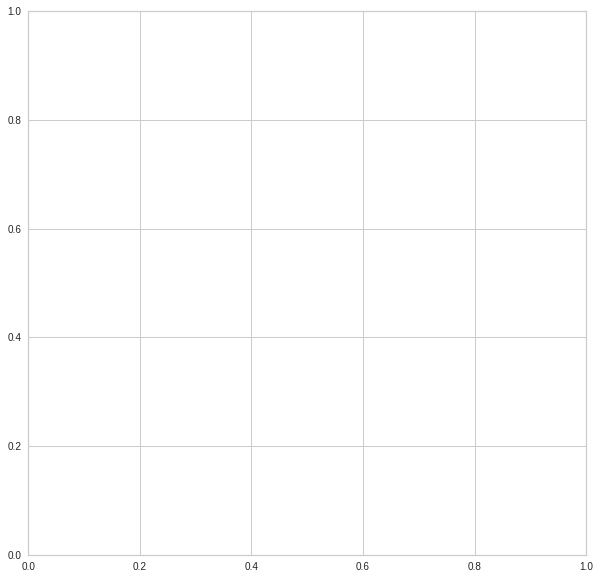

In [516]:
# Instantiate the visualizer with the Pearson ranking algorithm
fig, ax = plt.subplots(1, 1, figsize=(10,10))
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(X, y=None)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

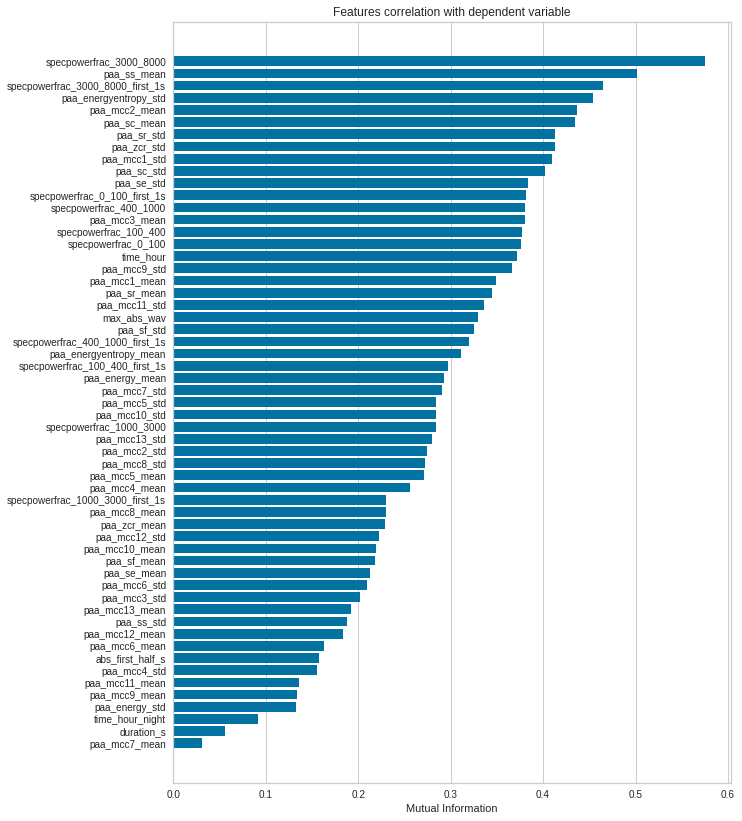

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [517]:
fig = plt.figure(figsize=(10,14))
visualizer = FeatureCorrelation(
    method='mutual_info-classification', feature_names=features, sort=True
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

This suggests which features might be most predictive.

## Modelling

### Split into train and test sets

In [518]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=331)
print(X_train.shape, y_test.shape)

(938, 57) (235,)


In [519]:
print(f'''Most common class is {y_train.value_counts().index[0]} at {y_train.value_counts().iloc[0]/len(y_train):.2f} of training samples 
so that is baseline accuracy''')

Most common class is background at 0.36 of training samples 
so that is baseline accuracy


### Fit and score random forest

In [520]:
clf = RandomForestClassifier(n_estimators=200, max_depth=8, 
                             min_samples_split=3, class_weight='balanced')

clf.fit(X_train, y_train)

print(f'Random Forest test accuracy = {clf.score(X_test, y_test):.2f}')
print(f'Cohen\'s kappa score = {cohen_kappa_score(y_test, clf.predict(X_test)):.2f}')

#~0.76 at first (1000 samples)
#~0.79 after adding some paa terms (up to MFCC3)
#~0.81 after adding rest of MFCC terms

Random Forest test accuracy = 0.78
Cohen's kappa score = 0.72


Feature importance:
- paa_ss_mean is top (spectral spread)
- my specpowerfrac terms are surprisingly good
- paa MCC mean terms come in high
- spectral centroid, rolloff are quite high
- duration_s and time_hour surprisingly not that important

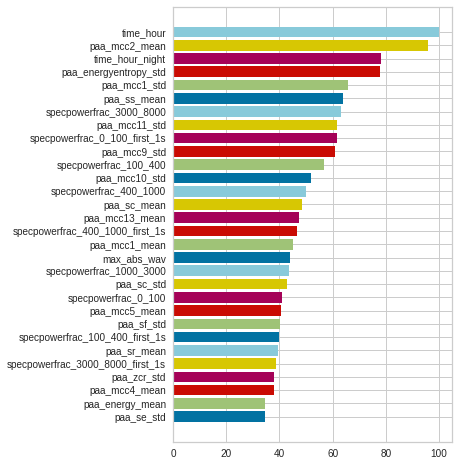

In [521]:
fig, ax = plt.subplots(1,1, figsize=(5,8))
_ = FeatureImportances(clf, is_fitted=True, topn=30)\
    .fit(X_train, y_train)  
#Not sure why this needs to fit something again, but model isn't changed if is_fitted=True

Most errors are putting window, cough, me talking into background.

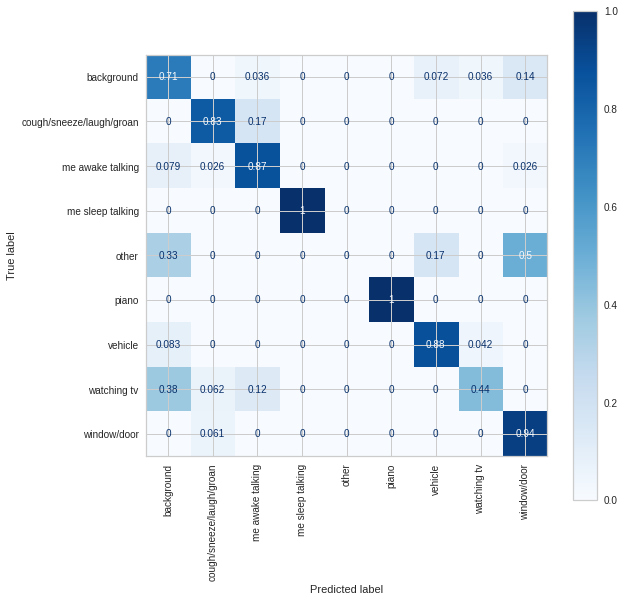

In [522]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, 
                                      normalize='true',
                                      cmap='Blues', xticks_rotation='vertical', ax=ax)

/home/david/.conda/envs/audio/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


Overall accuracy = 0.78


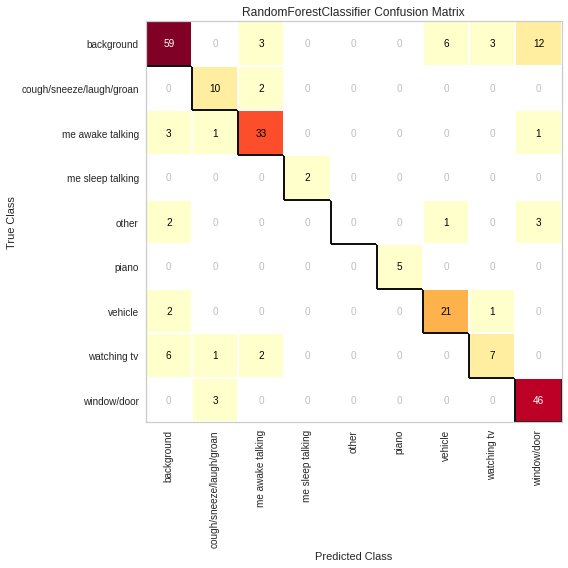

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [523]:
#Or use Yellowbrick

fig, ax = plt.subplots(1,1,figsize=(8,8))
viz = ConfusionMatrix(clf, is_fitted=True)
acc = viz.score(X_test, y_test)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(f'Overall accuracy = {acc:.2f}')
viz.show()

In [529]:
#Probabilities of background when predicted label is background
#  but true label is me talking
bk_class_ind = np.argwhere(np.unique(y_test)=='background')[0][0]

pred_background_true_metalking_bool = (y_test=='me talking') & (clf.predict(X_test)=='background')
print(f'This happens {sum(pred_background_true_metalking_bool)} times')

if sum(pred_background_true_metalking_bool) > 0:
    mt_probs = clf.predict_proba(X_test[pred_background_true_metalking_bool])[:, bk_class_ind]
    _ = sns.histplot(mt_probs, bins=30)

#-> 4/6 cases we would know to be cautious because top prob < 0.5

This happens 0 times


Overall test acc (235 cases) = 0.78
Test acc, top prob > 0.5 (150 cases) = 0.91
Test acc, top prob > 0.6 (112 cases) = 0.95


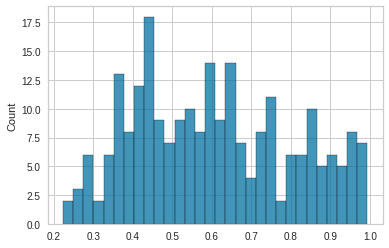

In [525]:
#Probabilities for most likely class 
#If we exclude the 20% most uncertain cases, accuracy increases by 8%

clf_most_likely_probs = clf.predict_proba(X_test).max(axis=-1)

print(f'Overall test acc ({sum(clf_most_likely_probs>0)} cases) = {np.mean(clf.predict(X_test)[clf_most_likely_probs > 0] == y_test[clf_most_likely_probs > 0]):.2f}')
print(f'Test acc, top prob > 0.5 ({sum(clf_most_likely_probs>0.5)} cases) = {np.mean(clf.predict(X_test)[clf_most_likely_probs > 0.5] == y_test[clf_most_likely_probs > 0.5]):.2f}')
print(f'Test acc, top prob > 0.6 ({sum(clf_most_likely_probs>0.6)} cases) = {np.mean(clf.predict(X_test)[clf_most_likely_probs > 0.6] == y_test[clf_most_likely_probs > 0.6]):.2f}')

_ = sns.histplot(clf_most_likely_probs, bins=30)

In [526]:
print(classification_report(y_test, clf.predict(X_test), zero_division=0))

                          precision    recall  f1-score   support

              background       0.82      0.71      0.76        83
cough/sneeze/laugh/groan       0.67      0.83      0.74        12
        me awake talking       0.82      0.87      0.85        38
        me sleep talking       1.00      1.00      1.00         2
                   other       0.00      0.00      0.00         6
                   piano       1.00      1.00      1.00         5
                 vehicle       0.75      0.88      0.81        24
             watching tv       0.64      0.44      0.52        16
             window/door       0.74      0.94      0.83        49

                accuracy                           0.78       235
               macro avg       0.72      0.74      0.72       235
            weighted avg       0.76      0.78      0.76       235



/home/david/.conda/envs/audio/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/david/.conda/envs/audio/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


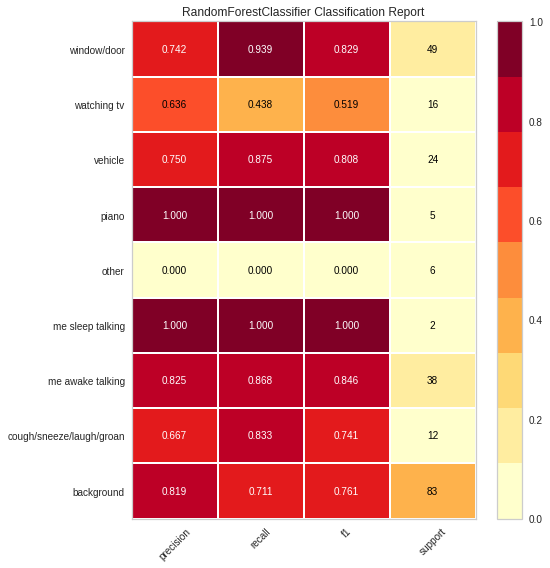

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [527]:
#Or use Yellowbrick

fig, ax = plt.subplots(1,1, figsize=(8,8))
visualizer = ClassificationReport(clf, is_fitted=True, support=True, classes=np.unique(y))
#visualizer.fit(X_train, y_train, zero_division=0)        #fit not needed
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
plt.savefig('test.png')
visualizer.show()                       # Finalize and show the figure

/home/david/.conda/envs/audio/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


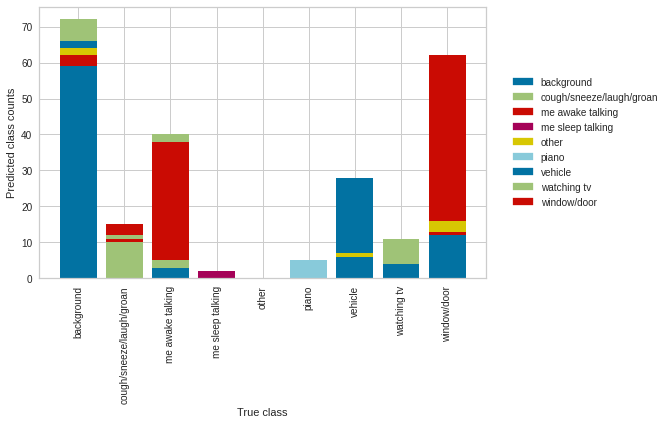

In [528]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.xlabel('True class')
plt.ylabel('Predicted class counts')
_ = ClassPredictionError(clf, is_fitted=True).score(X_test, y_test)

### Fit and score GBM

In [455]:
gbm = GradientBoostingClassifier(n_estimators=300, learning_rate=0.02,
                                 max_depth=4, min_samples_split=5,
                                 n_iter_no_change=5)

gbm.fit(X_train, y_train)

if gbm.n_estimators_ < gbm.n_estimators:
    print(f'Stopped at {gbm.n_estimators_} trees')

print(f'GBM test accuracy = {gbm.score(X_test, y_test):.2f}')
print(f'Cohen\'s kappa score = {cohen_kappa_score(y_test, gbm.predict(X_test)):.2f}')

Stopped at 140 trees
GBM test accuracy = 0.78
Cohen's kappa score = 0.72


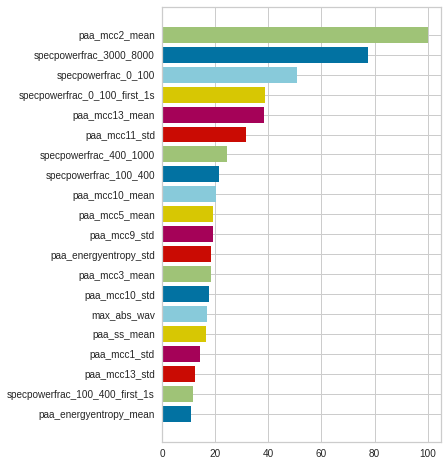

In [456]:
fig, ax = plt.subplots(1, 1, figsize=(5,8))
_ = FeatureImportances(gbm, is_fitted=True, topn=20)\
    .fit(X_train, y_train)  

/home/david/.conda/envs/audio/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


Overall accuracy = 0.78


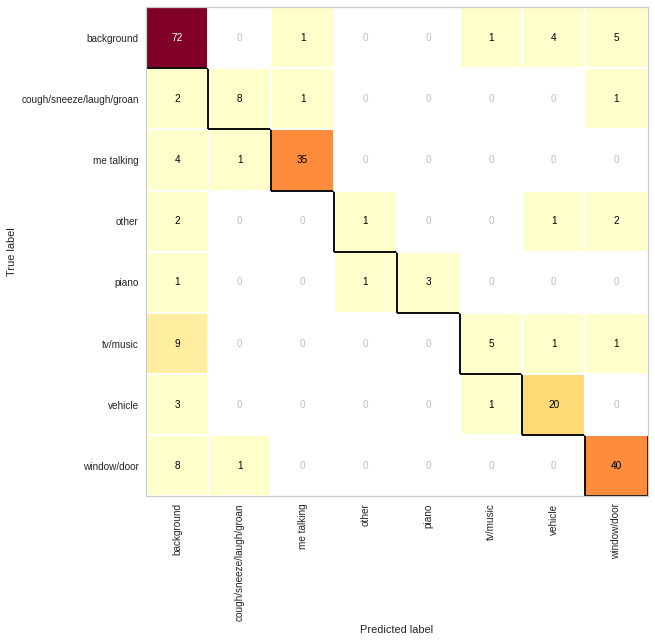

In [457]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
acc = ConfusionMatrix(gbm, is_fitted=True).score(X_test, y_test)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(f'Overall accuracy = {acc:.2f}')

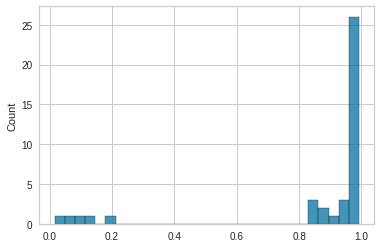

In [417]:
#Probabilities of 'me talking' when true label is that
mt_class_ind = np.argwhere(np.unique(y_test)=='me talking')[0][0]
mt_probs = gbm.predict_proba(X_test[y_test=='me talking'])[:,mt_class_ind]
_ = sns.histplot(mt_probs, bins=30)

#-> There are some that would definitely be missed atm (mostly going to background)

### Model tuning

See how changing hyperparameters affects models

- increasing max_depth over ~5-10 for RF does overfit but val accuracy is increasing

dict_keys(['ax', 'cv', 'estimator', 'groups', 'logx', 'n_jobs', 'param_name', 'param_range', 'pre_dispatch', 'scoring', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'random_state', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'groups', 'logx', 'n_jobs', 'param_name', 'param_range', 'pre_dispatch', 'scoring', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'random_state', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'groups', 'logx', 'n_jobs', 'param_name', 'param_range', 'pre_dispatch', 'scoring', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'm

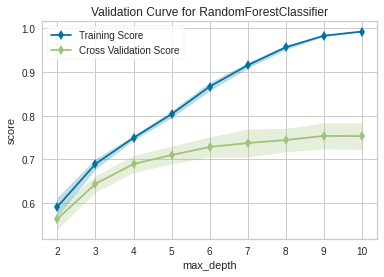

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [418]:
# Create the validation curve visualizer
#cv = StratifiedKFold(12)
#param_range = np.logspace(-6, -1, 12)

#Default is to do 3-fold cross validation
viz = ValidationCurve(
    RandomForestClassifier(n_estimators=200, min_samples_split=2), 
    param_name="max_depth", param_range=range(2,11),
    #cv=cv, 
    scoring="f1_weighted", n_jobs=3  #parallel is not working
)

_ = viz.fit(X_train, y_train)
viz.show()

And how increasing training size will help
- Only a few points gain from 200 to 600 samples

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

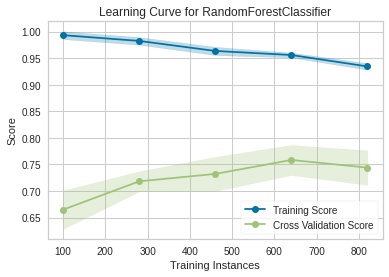

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [419]:
#len(y_train)  #704 currently, but this will do 8-fold cross val so the max is 704*7/8 = 616
#sizes = [100,200,350,500,615]

sizes = np.linspace(100, len(y_train)*7/8,5).astype(int)

visualizer = LearningCurve(
    RandomForestClassifier(n_estimators=300, 
                           max_depth=8, 
                           min_samples_split=5), 
    cv = 8,  #increase from (default seems to be) 5 so that we can get closer to using all samples
    scoring='f1_weighted', train_sizes=sizes, n_jobs=2
)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure